In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:

!kaggle datasets download samithsachidanandan/human-face-emotions

Dataset URL: https://www.kaggle.com/datasets/samithsachidanandan/human-face-emotions
License(s): apache-2.0
 89% 622M/701M [00:06<00:01, 54.6MB/s]
100% 701M/701M [00:06<00:00, 109MB/s] 


In [18]:
import zipfile
zip_ref = zipfile.ZipFile('/content/human-face-emotions.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Displaying Random Samples per Class : 



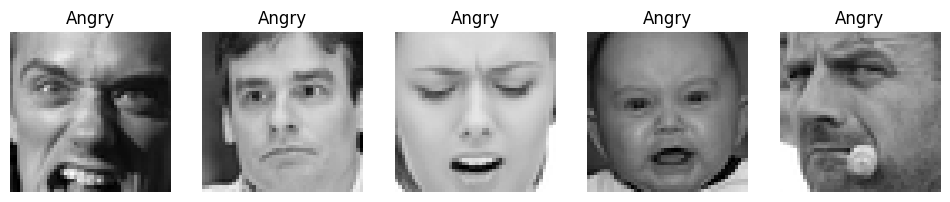

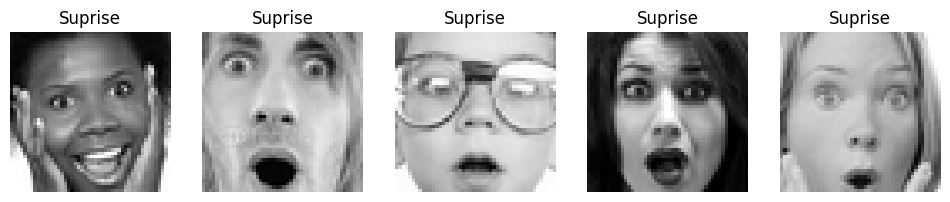

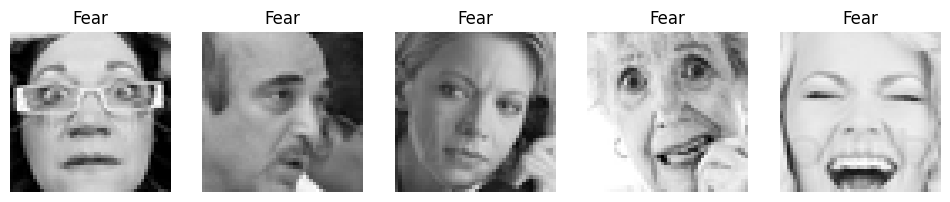

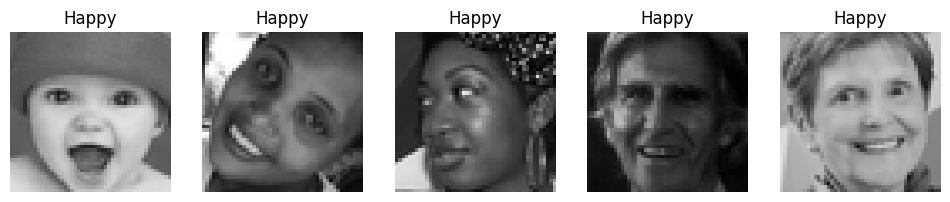

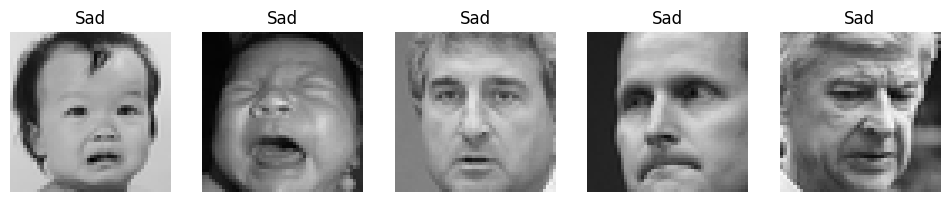

In [28]:
import os
import random
import cv2
import matplotlib.pyplot as plt

base_path = "/content/Data"
folders = os.listdir(base_path)

def show_images(base_path, class_name):

    folder_path = os.path.join(base_path, class_name)

    # get all images in folder
    all_images_names = os.listdir(folder_path)

    # choose random 5 images
    random_images_names = random.sample(all_images_names, 5)


    plt.figure(figsize=(12, 3))

    for i, img_name in enumerate(random_images_names):
        img_path = os.path.join(folder_path, img_name)

        img = cv2.imread(img_path) # image is 48*48*3
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

    plt.show()


print("Displaying Random Samples per Class : \n")

for cls in folders:
    show_images(base_path, cls)

Class 'Angry': 10148 images
Class 'Suprise': 8227 images
Class 'Fear': 9732 images
Class 'Happy': 18439 images
Class 'Sad': 12553 images


/tmp/ipython-input-4289597950.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')


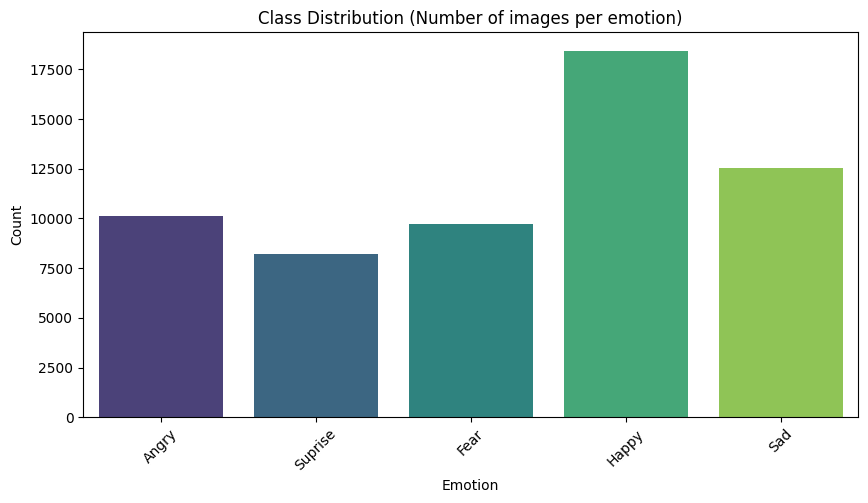

In [30]:
import seaborn as sns
import os
import matplotlib.pyplot as plt

class_counts = {}
for cls in folders:
    folder_path = os.path.join(base_path, cls);
    count = len(os.listdir(folder_path))
    class_counts[cls] = count
    print(f"Class '{cls}': {count} images")


plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
plt.title("Class Distribution (Number of images per emotion)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64


train_datagen = ImageDataGenerator(
    rescale=1./255,           # normalize pixel values to range 0-1
    rotation_range=10,        # random rotation up to 10 degrees(left/right)
    width_shift_range=0.1,    # shift image horizontally by 10%(left/right)
    height_shift_range=0.1,   # shift image vertically by 10%(up/down)
    shear_range=0.1,          # apply shearing transformation
    zoom_range=0.1,           # random zoom in/out by 10%
    horizontal_flip=True,     # randomly flip image horizontally
    fill_mode='nearest',      # fill new pixels with nearest value
    validation_split=0.2      # reserve 20% of data for validation
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [33]:
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # for multi-class / one hot encode
    color_mode='rgb',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=False
)

Found 47282 images belonging to 5 classes.
Found 11817 images belonging to 5 classes.


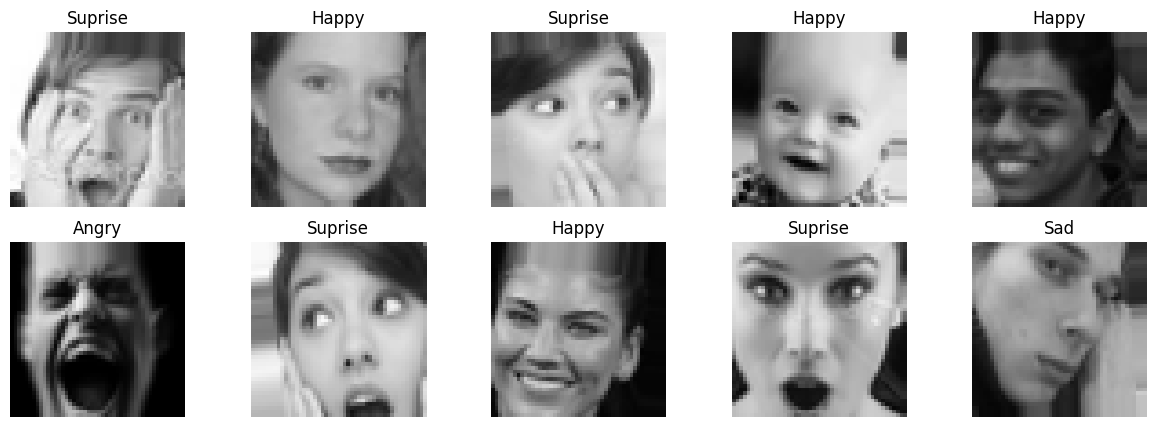

In [34]:
class_names = list(train_generator.class_indices.keys())

images, labels = next(train_generator)
# display first 10 images
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])

    label_index = labels[i].argmax() # [0,0,1,0,0]
    plt.title(class_names[label_index])
    plt.axis("off")

plt.show()

In [36]:
import numpy as np
from sklearn.utils import class_weight

train_classes = train_generator.classes

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_classes),
    y=train_classes
)

# to use it with keras convert it to dictionary
class_weights_dict = dict(enumerate(class_weights))


class_names = list(train_generator.class_indices.keys())
for i, name in enumerate(class_names):
    print(f"Class '{name}': Weight = {class_weights_dict[i]:.2f}")

Class 'Angry': Weight = 1.16
Class 'Fear': Weight = 1.21
Class 'Happy': Weight = 0.64
Class 'Sad': Weight = 0.94
Class 'Suprise': Weight = 1.44


In [37]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [38]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

In [39]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer_4 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [40]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [50]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(len(class_names),activation='softmax'))

In [51]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = base_path, # Changed path to base_path
    labels='inferred',
    label_mode = 'categorical', # Changed to categorical for multi-class
    batch_size=32,
    image_size=(150,150),
    validation_split=0.2, # Added validation split
    subset='training',
    seed=42 # Added seed for reproducibility
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = base_path, # Changed path to base_path
    labels='inferred',
    label_mode = 'categorical', # Changed to categorical for multi-class
    batch_size=32,
    image_size=(150,150),
    validation_split=0.2, # Added validation split
    subset='validation',
    seed=42 # Added seed for reproducibility
)

Found 59099 files belonging to 5 classes.
Using 47280 files for training.
Found 59099 files belonging to 5 classes.
Using 11819 files for validation.


In [52]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [55]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )
es = EarlyStopping(monitor='val_accuracy',patience=5,verbose=1,mode='max')
lr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,mode='max')

In [56]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds,callbacks=(es,lr))

Epoch 1/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 272s 182ms/step - accuracy: 0.6231 - loss: 0.3282 - val_accuracy: 0.6681 - val_loss: 0.2899 - learning_rate: 1.0000e-05
Epoch 2/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 293s 199ms/step - accuracy: 0.7168 - loss: 0.2630 - val_accuracy: 0.7158 - val_loss: 0.2616 - learning_rate: 1.0000e-05
Epoch 3/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 294s 199ms/step - accuracy: 0.7825 - loss: 0.2189 - val_accuracy: 0.7532 - val_loss: 0.2368 - learning_rate: 1.0000e-05
Epoch 4/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 255s 172ms/step - accuracy: 0.8341 - loss: 0.1822 - val_accuracy: 0.7869 - val_loss: 0.2123 - learning_rate: 1.0000e-05
Epoch 5/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 300s 198ms/step - accuracy: 0.8748 - loss: 0.1512 - val_accuracy: 0.8123 - val_loss: 0.1960 - learning_rate: 1.0000e-05
Epoch 6/10
1478/1478 ━━━━━━━━━━━━━━━━━━━━ 256s 173ms/step - accuracy: 0.9102 - loss: 0.1234 - val_accuracy: 0.8240 - val_loss: 0.1837 - learning_rate: 1.0000e-05
Epoch 7/10
1478/1478 ━━━━━━━

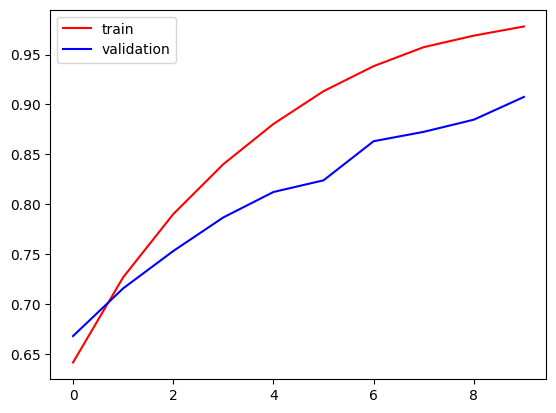

In [57]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

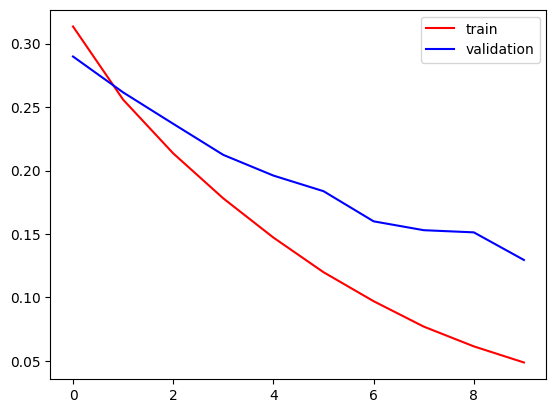

In [58]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [75]:
import pickle

# Save the model as a pickle file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved as model.pkl")

Model saved as model.pkl
